In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [26]:
# get best percentage for each model
def get_best_percentage(directory, iterations=10):
    # get all *-improvement-history.json files in the model directory
    path = f'{directory}/*-improvement_history.jsonl'
    improvement_files = glob.glob(path)
    # get the best percentage for each file
    best_percentages = []
    for file in improvement_files:
        with open(file, 'r') as f:
            improvement_history = pd.read_json(file, lines=True)
            best_percentages.append(improvement_history[improvement_history['attempt'] < iterations]['percent'].max())
    return best_percentages

In [39]:
# iterate over all directories in 'final-results'
models = [dir for dir in os.listdir('final-results')]
print(models)

df = []
# create heatmap by generating a matrix of the best percentage for each model
for attacker_model in models:
    for eval_model in models:
        if attacker_model == "gpt-4o" or eval_model == "gpt-4o":
            print("skipping gpt-4o -- not implemented")
            continue

        percentages = []
        if attacker_model == eval_model:
            percentages = get_best_percentage(f"final-results/{eval_model}/attack")
        
        else:
            percentages = get_best_percentage(f"final-results/{eval_model}/transferability/{attacker_model}")
        
        if len(percentages) == 0:
            continue

        attack_success_rate = np.mean(percentages)

        # add to dataframe
        # The issue is that when you pass a dictionary of scalars to pd.DataFrame, pandas doesn't know how many rows to create.
        # Instead, wrap each value in a list so pandas creates a single-row DataFrame.
        df.append({'attacker_model': attacker_model, 'eval_model': eval_model, 'attack_success_rate': attack_success_rate})
        # break
    # break
        
df = pd.DataFrame(df)
df
        
    


['deepseek-chat', 'gpt-oss', '.DS_Store', 'qwen2.5', 'gpt-4o', 'llama3.1', 'gemini-2.5-flash-lite']
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented


,attacker_model,eval_model,attack_success_rate
0,deepseek-chat,deepseek-chat,81.62
1,deepseek-chat,gpt-oss,45.88
2,deepseek-chat,qwen2.5,39.82
3,deepseek-chat,llama3.1,35.32
4,deepseek-chat,gemini-2.5-flash-lite,28.90
5,gpt-oss,deepseek-chat,71.04
6,gpt-oss,gpt-oss,73.62
7,gpt-oss,qwen2.5,55.36
8,gpt-oss,llama3.1,34.98
9,gpt-oss,gemini-2.5-flash-lite,41.32


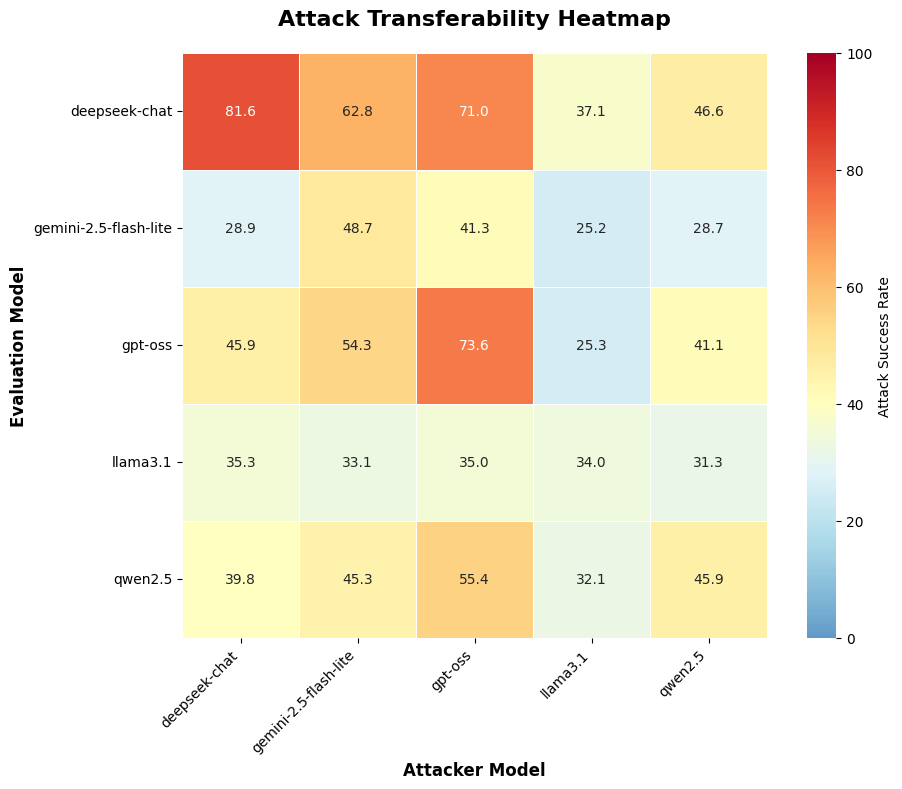

In [40]:
# Pivot the data to create a matrix format
heatmap_data = df.pivot(index='eval_model', columns='attacker_model', values='attack_success_rate')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, 
            annot=True,           # Show values in cells
            fmt='.1f',            # Format numbers to 1 decimal place
            cmap='RdYlBu_r',      # Color scheme (red-yellow-blue reversed)
            cbar_kws={'label': 'Attack Success Rate'}, # Color bar label
            square=True,          # Make cells square
            linewidths=0.5,       # Add grid lines
            center=40,
            linecolor='white',
            vmin=0,
            vmax=100)    # White grid lines

plt.title('Attack Transferability Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Attacker Model', fontsize=12, fontweight='bold')
plt.ylabel('Evaluation Model', fontsize=12, fontweight='bold')

# Rotate labels if they're long
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [41]:

# iterate over all directories in 'final-results'
models = [dir for dir in os.listdir('final-results')]
print(models)

df = []
# read attack, baseline-attack, and baseline-defended
for model in models:
    # read attack, baseline-attack, and baseline-defended, and defended
    for folder in ['attack', 'baseline-attack', 'baseline-defended', 'defended']:
        # read all *-improvement-history.jsonl files in the model directory
        percentages = get_best_percentage(f"final-results/{model}/{folder}")
        if not percentages:
            continue
        attack_success_rate = np.mean(percentages)

        df.append({'model': model, 'setting': folder, 'attack_success_rate': attack_success_rate})

        
df = pd.DataFrame(df)
df.pivot(index='setting', columns='model', values='attack_success_rate')
        


['deepseek-chat', 'gpt-oss', '.DS_Store', 'qwen2.5', 'gpt-4o', 'llama3.1', 'gemini-2.5-flash-lite']


model,deepseek-chat,gemini-2.5-flash-lite,gpt-4o,gpt-oss,llama3.1,qwen2.5
setting,,,,,,
attack,81.62,48.66,23.08,73.62,33.96,45.92
baseline-attack,68.66,56.10,NaN,76.44,38.12,61.26
baseline-defended,30.20,21.32,NaN,37.50,20.44,32.76
defended,48.64,30.16,NaN,63.30,27.24,34.30
